## 功能函数  
- plot_distribution(data,) 特征分布  
- regularize_date(date) 时间字符串转化为数值型（不转化为时间戳，考虑到早于1970会报错）  
- split_word(word) 自定义分词并且正则过滤掉文本中指定符号  
- getkeyword(sentence) 提取文本关键词函数  

In [2]:
# enumerate函数 产生枚举对象，是一个迭代器
[*enumerate(['a','b'])]

[(0, 'a'), (1, 'b')]

In [3]:
# 查看特征分布
def plot_distribution(data,):
    feature = data.name
    figure, ax = plt.subplots(figsize=(5,5))
    ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    # 画出直方图，用于查看数据分布情况
    ax.hist(data, bins = 50)

In [4]:
# 时间转化为整形数字
def regularize_date(date):
    str=''
    for i in date.split('/'):
        if len(i) >= 2:
            str = i + str
        else:
            str = '0' + i +str
    return int(str)

In [5]:
# 处理文本信息,方便分词
import re
def removePunctuation(text):
    # punctuation 自定义re查询字符
    # 
    punctuation = '!,;:.?"\'(){}\[\]/#$%^&*\-+_`'
    text = re.sub(r'[{}]+'.format(punctuation),' ',text)
    return text.strip().lower()

# 自定义分词函数（nltk用不了）
def split_word(word):
    word_clean = removePunctuation(word)
    return word_clean.split() # 默认传参分割任何空格

In [6]:
# 取TFIDF模型中最大的值并转化为文本输出
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
# sentence 分好词的句子 [[],[]]
# 返回list类型
def getkeyword(sentence):
    # dictionary 按输入sentence生成的词典对象
    # new_corpus 计算语料库
    # corpus_tfidf 按照语料库生成的tfidf模型
    # 做成词典，给每个词打上ID
    dictionary = Dictionary(sentence)

    # 以 (词id,词频) 的方式记录每个词在每个sentence中出现的次数，
    # dictionary.doc2bow(i) i是一个"句子"，并且要求以list存放的分好词的"句子"，会返回每个词在该"句子"中的词频
    new_corpus = [dictionary.doc2bow(i) for i in sentence]
    
    # 训练TF-IDF模型
    tfidf = TfidfModel(new_corpus)
    
    # 从模型中获取每个词的tfidf, 以 (词id, TFIDF) 返回迭代器
    corpus_tfidf = tfidf[new_corpus]
    
    # 从每个句子中获取最大tfidf的词作为该句子的关键词
    keywords = []
    for line in corpus_tfidf:
        c = 0
        v = 0
        for i in line:
            if i[1] > c:
                c = i[1]
                v = i[0]
        # 最后希望输出词语，而不是词id
        keywords.append(dictionary.get(v))
    return keywords

## 数据清洗  
- 特征publication_date转数值型，方便喂模型和做归一化  
- 

In [7]:
# 基于MLP
# 引入特征工程所需要的的lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec                   # 词向量模型，输入语料库，以训练模型
from sklearn.model_selection import train_test_split # 将数据集划分成训练集和测试集
from sklearn import metrics                          # 测试需要用到
from sklearn.preprocessing import MinMaxScaler       # 最大最小归一化（干净数据中广泛应用）
from sklearn.preprocessing import StandardScaler       # 标准差归一化（广泛应用）
from IPython.display import display                  # 更好的对dataframe结构输出展示
from time import time
from pprint import pprint

In [8]:
# 导入数据
data_path      = 'Train_data.csv'
data_verification_path = 'Test_data.csv'
data           = pd.read_csv(data_path, encoding='utf-8')
data_verification      = pd.read_csv(data_verification_path, encoding='utf-8')
#data.columns.apply(lambda x:strip(x))

# 除去字段空格
data.columns = [i.strip() for i in data.columns]
# 处理时间字段,转化为时间戳
data.publication_date = data.publication_date.apply(lambda x : regularize_date(x))

# 查看数据整体情况
display(data.head(),data.shape)

# 是否存在缺失值
display(data.isnull().any(axis = 0))

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,8253,Little Town on the Prairie (Little House #7),Laura Ingalls Wilder/Garth Williams,4.19,0060885432,9780060885434,eng,374,71853,646,20070101,HarperTrophy
1,11101,First Comes Love (Hot Water California #1),Christie Ridgway,3.81,0380818957,9780380818952,en-US,384,1051,47,20020101,Avon Books
2,28193,When Santa Fell to Earth,Cornelia Funke/Paul Howard/Oliver G. Latsch,3.76,043978204X,9780439782043,eng,167,1840,245,20060110,Chicken House / Scholastic
3,25047,The Case of the Stinky Science Project (Jigsaw...,James Preller/John Speirs/James Preller,3.83,0439114284,9780439114288,en-US,80,162,11,20010103,Scholastic Paperbacks
4,17800,Dance Dance Dance,Haruki Murakami,4.04,0099448769,9780099448761,eng,393,50169,2117,20020702,Vintage


(10000, 12)

bookID                False
title                 False
authors               False
average_rating        False
isbn                  False
isbn13                False
language_code         False
num_pages             False
ratings_count         False
text_reviews_count    False
publication_date      False
publisher             False
dtype: bool

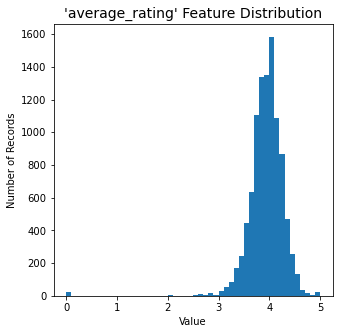

In [9]:
# 查看预测目标、即感兴趣的特征的分布情况
plot_distribution(data.average_rating, )

0       6.472346
1       3.871201
2       5.505332
3       2.484907
4       7.658228
          ...   
9995    2.079442
9996    6.068426
9997    2.397895
9998    0.000000
9999    2.079442
Name: log_text_reviews_count, Length: 10000, dtype: float64

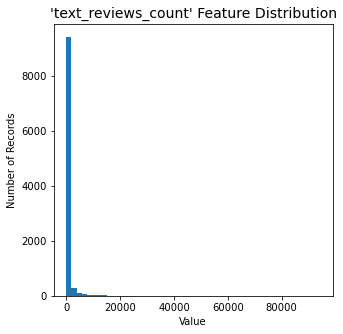

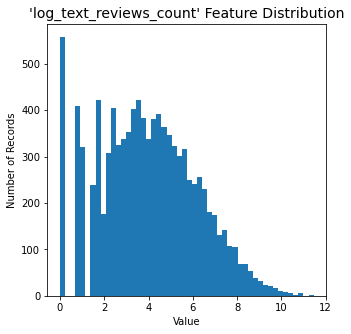

In [10]:
# text_reviews_count 评论数量
plot_distribution(data.text_reviews_count, )
dealt_data = data.text_reviews_count.apply(lambda x:np.log(x+1))
dealt_data.name = 'log_text_reviews_count'
display(dealt_data)
plot_distribution(dealt_data, )

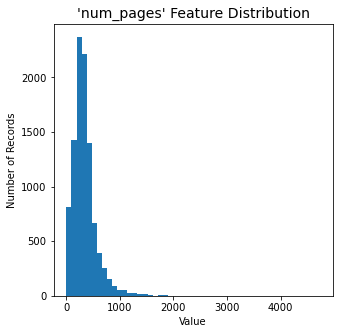

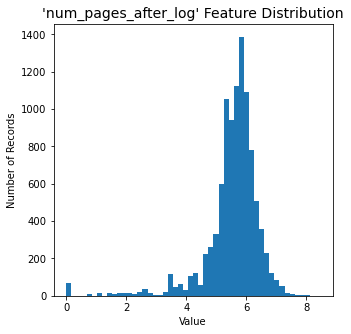

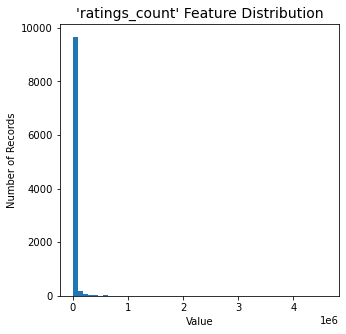

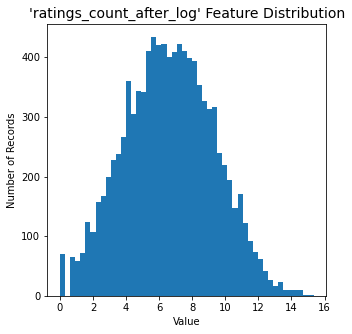

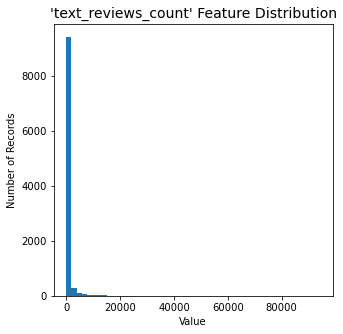

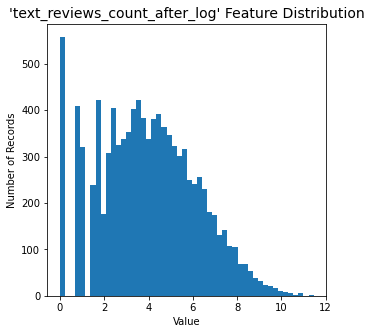

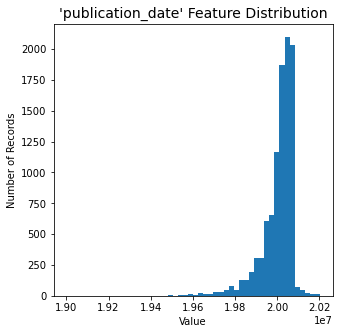

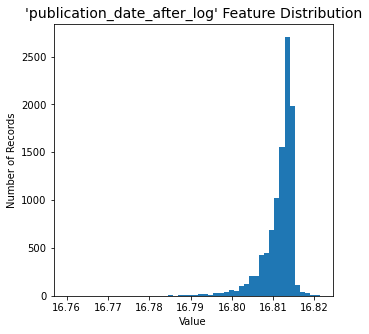

In [11]:
# 先重点关注几个continuous data特征
for i in ['num_pages', 'ratings_count', 'text_reviews_count', 'publication_date']:
    try:
        plot_distribution(data[i], )
        # 用sigmoid函数
        med_data = data[i].apply(lambda x: np.log(x+1))
        med_data.name = i + '_after_log'
        plot_distribution(med_data, )
    except BaseException as e:
        print(e)

### 文本处理

In [12]:
# 1.2.1 分词预训练词向量

title_data = pd.concat([data.title, data_verification.title], ignore_index=1)
authors_data = pd.concat([data.authors, data_verification.authors], ignore_index=1)
publisher_data = pd.concat([data.publisher, data_verification.publisher], ignore_index=1)

title_sentence = []
for i in title_data: 
    title_sentence.append(split_word(i))

authors_sentence = []
for i in authors_data:
    authors_sentence.append(split_word(i))

publisher_sentence = []
for i in publisher_data:
    publisher_sentence.append(split_word(i))

sentence = title_sentence + authors_sentence + publisher_sentence
    
num = 0
for i in sentence:
    for j in i:
        num = num+ 1

print('分词结束,取top3句子检查：\n', sentence[:3])
print('看看一共有多少个句子和词语:', len(sentence), num)

分词结束,取top3句子检查：
 [['little', 'town', 'on', 'the', 'prairie', 'little', 'house', '7'], ['first', 'comes', 'love', 'hot', 'water', 'california', '1'], ['when', 'santa', 'fell', 'to', 'earth']]
看看一共有多少个句子和词语: 33000 134650


In [13]:
# 1.2.2 把文本数据转化词向量
# min_count = 1 由于数据集很小,所以有1个就会进入计算,防止词丢失
w2v_model = Word2Vec(sentences=sentence, size=50, min_count=1)
w2v_model.save("bdc_word2vec_ver2.model")
w2v_model = Word2Vec.load('bdc_word2vec_ver2.model')

In [44]:
print('After w2v model established, We can show the \'computer\' vectors in 50 dimension:\n', w2v_model.wv[['computer']])

After w2v model established, We can show the 'computer' vectors in 50 dimension:
 [[-0.04867544 -0.07061413 -0.0556491   0.11987265 -0.00679415 -0.11405369
   0.03042728 -0.04136446  0.01715099 -0.02672699 -0.00894067 -0.01077261
   0.00529564  0.07949136 -0.00735611 -0.09824823 -0.05929496  0.03058917
  -0.09104651 -0.09990288  0.01863842  0.03941646  0.07482628 -0.04560623
   0.1129244   0.00030893 -0.01645838  0.02541166 -0.02928171 -0.02117754
  -0.06405578  0.03590215  0.06143368  0.10010786 -0.03779603 -0.08585156
   0.09500747 -0.03230895 -0.03487857 -0.0200028  -0.01952527 -0.00981329
   0.03754389  0.12878717 -0.10312779  0.12510026  0.05482448  0.05476829
   0.05778817  0.03823117]]


In [15]:
title_array = np.array(title_sentence)
title_wvl = [] 
for seq in title_array:
    wvv = w2v_model.wv[seq]
    title_wvl.append(np.sum(wvv, axis=0))

# 把原title的关键词，转化为N维词向量表示
title_data = title_wvl[:len(data.title)]
title_data_verification = title_wvl[-len(data_verification.title):]

In [16]:
authors_array = np.array(authors_sentence)
authors_wvl = [] 
for seq in authors_array:
    wvv = w2v_model.wv[seq]
    authors_wvl.append(np.sum(wvv, axis=0))
# 把原title的关键词，转化为N维词向量表示
authors_data = authors_wvl[:len(data.title)]
authors_data_verification = authors_wvl[-len(data_verification.title):]

In [17]:
publisher_array = np.array(publisher_sentence)
publisher_wvl = [] 
for seq in publisher_array:
    wvv = w2v_model.wv[seq]
    publisher_wvl.append(np.sum(wvv, axis=0))
# 把原title的关键词，转化为N维词向量表示
publisher_data = publisher_wvl[:len(data.title)]
publisher_data_verification = publisher_wvl[-len(data_verification.title):]

In [18]:
len(title_data)

10000

In [19]:
len(authors_data)

10000

In [20]:
len(publisher_data)
publisher_data[:1]

[array([-0.00487887,  0.00576321, -0.00905111,  0.00959743, -0.00850092,
        -0.00265955, -0.00046002,  0.00155328, -0.00431072, -0.00750694,
         0.00782146, -0.00293981,  0.00016165, -0.00032851, -0.00949068,
        -0.00687344,  0.00951612, -0.00484674, -0.00377556,  0.0072666 ,
        -0.00444108,  0.00175532, -0.00989094, -0.0010715 ,  0.00221951,
         0.00851253,  0.00843004,  0.00338173, -0.00598586,  0.00554956,
        -0.00466181,  0.00568081,  0.00864834,  0.00868106, -0.00125624,
        -0.0032295 , -0.00255207,  0.00997987,  0.00480979,  0.00083727,
        -0.0051767 , -0.00088202, -0.00885135,  0.00717708,  0.00132905,
        -0.00210073, -0.00233127,  0.00167049,  0.00847516,  0.00203657],
       dtype=float32)]

### 进一步处理数据
- 在原数据集后，拼接词向量数据
- 对多值文本属性，做one-hot编码（注意考虑合并离群点）

In [21]:
# 注意这里只处理了训练集和测试集，没有老师最终检查的数据集
# 先简化下数据集吧, 先不处理publisher和authors两个字段
# 构建新的数据集，先drop了出版者和作者，看看词向量效果如何
new_data = data.drop(columns=['title', 'publisher', 'authors', 'isbn13', 'isbn', 'bookID'])
title_vec = pd.DataFrame(title_data, columns=[('title_vec_'+str(i)) for i in range(len(title_data[0]))])
authors_vec = pd.DataFrame(authors_data, columns=[('authors_vec_'+str(i)) for i in range(len(authors_data[0]))])
publisher_vec = pd.DataFrame(publisher_data, columns=[('publisher_vec_'+str(i)) for i in range(len(publisher_data[0]))])

In [22]:
display(title_vec.head(100))

,title_vec_0,title_vec_1,title_vec_2,title_vec_3,title_vec_4,title_vec_5,title_vec_6,title_vec_7,title_vec_8,title_vec_9,...,title_vec_40,title_vec_41,title_vec_42,title_vec_43,title_vec_44,title_vec_45,title_vec_46,title_vec_47,title_vec_48,title_vec_49
0,-3.747098,-5.183464,-3.948022,9.288079,-0.810517,-8.582615,2.144993,-2.862621,1.264742,-2.754216,...,-0.832452,-1.311187,3.516327,9.615289,-7.835669,9.561781,4.608453,3.822323,5.037406,2.323871
1,-1.876507,-2.571156,-2.114251,5.037493,-0.336496,-4.675576,1.140713,-1.501432,0.626258,-1.472901,...,-0.715463,-0.197880,1.370899,5.048478,-4.555610,5.050848,2.029786,2.268527,2.488799,1.477013
2,-1.506766,-1.931098,-1.681336,3.613956,-0.388189,-3.226217,0.650032,-0.918297,0.410814,-1.138032,...,-0.629202,-0.073347,0.988004,3.911835,-3.445247,3.869387,1.479301,1.556501,1.873836,1.094234
3,-3.958423,-4.277666,-4.267037,9.748462,-1.767044,-8.796388,1.835700,-3.020895,0.725848,-2.709273,...,-2.248287,-1.367883,3.088196,9.984613,-9.680996,10.526553,3.905707,5.253341,5.452207,3.053945
4,-0.431058,-0.584463,-0.507015,1.081211,-0.059922,-1.018359,0.252324,-0.305050,0.121998,-0.352929,...,-0.162990,-0.025518,0.317985,1.133290,-1.044718,1.167171,0.435748,0.432448,0.543172,0.319133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.170390,-0.234173,-0.175883,0.401935,-0.019892,-0.388190,0.100955,-0.122335,0.057536,-0.128274,...,-0.040419,0.003005,0.116908,0.409789,-0.368727,0.399769,0.148578,0.165796,0.195426,0.110757
96,-1.195731,-1.756125,-1.352631,3.132802,-0.157029,-2.967332,0.716541,-0.912159,0.364497,-0.911540,...,-0.458943,-0.017392,0.887739,3.235247,-2.910161,3.092261,1.207691,1.338416,1.520431,0.938043
97,-0.169871,-0.262603,-0.171004,0.433081,-0.021774,-0.404352,0.068825,-0.109072,0.050081,-0.138017,...,-0.034771,0.004136,0.097239,0.420765,-0.354964,0.380692,0.166196,0.159417,0.203422,0.093321
98,-1.014735,-0.936838,-0.994980,2.273813,-0.537598,-2.010156,0.345903,-0.713477,0.079725,-0.623105,...,-0.664191,-0.388088,0.794025,2.411012,-2.375342,2.542662,0.930985,1.322937,1.293086,0.741767


In [23]:
new_data = pd.concat([new_data , authors_vec], axis=1)
display(new_data)

,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,authors_vec_0,authors_vec_1,authors_vec_2,authors_vec_3,...,authors_vec_40,authors_vec_41,authors_vec_42,authors_vec_43,authors_vec_44,authors_vec_45,authors_vec_46,authors_vec_47,authors_vec_48,authors_vec_49
0,4.19,eng,374,71853,646,20070101,-1.244421,-1.906840,-1.431564,3.245332,...,-0.416375,0.106909,0.931141,3.450296,-2.920350,3.216386,1.336275,1.261265,1.552570,0.932937
1,3.81,en-US,384,1051,47,20020101,-0.134998,-0.222632,-0.162950,0.358591,...,-0.021412,0.016153,0.092762,0.386335,-0.326532,0.349787,0.118329,0.132508,0.191073,0.115830
2,3.76,eng,167,1840,245,20060110,-1.857821,-2.790849,-2.197726,4.911423,...,-0.571363,0.291356,1.200997,5.063437,-4.437582,5.017907,1.792845,1.745909,2.227508,1.332168
3,3.83,en-US,80,162,11,20010103,-2.318491,-3.407592,-2.717283,6.091428,...,-0.846028,0.567841,1.412400,6.425838,-5.405662,6.112884,2.382335,2.272966,2.810908,1.812282
4,4.04,eng,393,50169,2117,20020702,-0.265307,-0.388581,-0.317364,0.702553,...,-0.070610,0.010903,0.196423,0.720186,-0.629706,0.688273,0.256175,0.274580,0.324363,0.197401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4.10,eng,768,66,7,19912412,-2.333563,-3.387136,-2.824610,6.380114,...,-0.722987,0.522263,1.396523,6.518394,-5.686976,6.839650,2.233066,2.109915,2.763340,1.703287
9996,3.46,eng,161,6994,431,20002607,-0.255728,-0.409509,-0.331025,0.709613,...,-0.087952,0.021086,0.199569,0.724813,-0.661860,0.728960,0.308095,0.245310,0.339206,0.189007
9997,4.08,eng,425,81,10,19970508,-0.561119,-0.826468,-0.678402,1.480750,...,-0.168054,0.051815,0.394120,1.545598,-1.338427,1.486665,0.586008,0.554632,0.700849,0.405068
9998,3.90,spa,432,2,0,20060711,-0.810765,-1.202431,-0.998339,2.193121,...,-0.280197,0.055028,0.572987,2.255601,-1.958592,2.178580,0.840532,0.864513,1.000224,0.618154


In [24]:
# one-hot encode
from sklearn.preprocessing import LabelEncoder

# 先对language_encode进行预处理，
# 首先将少量编码类型合并
# 用正则方式实现类SQL where方法
get_bool = new_data['language_code'].str.contains(r'^(?:(?!eng|en-US|en-GB|spa|fre|ger|jpn).)*$')

new_data['language_code'][get_bool] = 'codex'

display(new_data)
display(new_data['language_code'].value_counts())

<ipython-input-24-320757d35393>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['language_code'][get_bool] = 'codex'


,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,authors_vec_0,authors_vec_1,authors_vec_2,authors_vec_3,...,authors_vec_40,authors_vec_41,authors_vec_42,authors_vec_43,authors_vec_44,authors_vec_45,authors_vec_46,authors_vec_47,authors_vec_48,authors_vec_49
0,4.19,eng,374,71853,646,20070101,-1.244421,-1.906840,-1.431564,3.245332,...,-0.416375,0.106909,0.931141,3.450296,-2.920350,3.216386,1.336275,1.261265,1.552570,0.932937
1,3.81,en-US,384,1051,47,20020101,-0.134998,-0.222632,-0.162950,0.358591,...,-0.021412,0.016153,0.092762,0.386335,-0.326532,0.349787,0.118329,0.132508,0.191073,0.115830
2,3.76,eng,167,1840,245,20060110,-1.857821,-2.790849,-2.197726,4.911423,...,-0.571363,0.291356,1.200997,5.063437,-4.437582,5.017907,1.792845,1.745909,2.227508,1.332168
3,3.83,en-US,80,162,11,20010103,-2.318491,-3.407592,-2.717283,6.091428,...,-0.846028,0.567841,1.412400,6.425838,-5.405662,6.112884,2.382335,2.272966,2.810908,1.812282
4,4.04,eng,393,50169,2117,20020702,-0.265307,-0.388581,-0.317364,0.702553,...,-0.070610,0.010903,0.196423,0.720186,-0.629706,0.688273,0.256175,0.274580,0.324363,0.197401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4.10,eng,768,66,7,19912412,-2.333563,-3.387136,-2.824610,6.380114,...,-0.722987,0.522263,1.396523,6.518394,-5.686976,6.839650,2.233066,2.109915,2.763340,1.703287
9996,3.46,eng,161,6994,431,20002607,-0.255728,-0.409509,-0.331025,0.709613,...,-0.087952,0.021086,0.199569,0.724813,-0.661860,0.728960,0.308095,0.245310,0.339206,0.189007
9997,4.08,eng,425,81,10,19970508,-0.561119,-0.826468,-0.678402,1.480750,...,-0.168054,0.051815,0.394120,1.545598,-1.338427,1.486665,0.586008,0.554632,0.700849,0.405068
9998,3.90,spa,432,2,0,20060711,-0.810765,-1.202431,-0.998339,2.193121,...,-0.280197,0.055028,0.572987,2.255601,-1.958592,2.178580,0.840532,0.864513,1.000224,0.618154


eng      8001
en-US    1285
en-GB     189
spa       187
fre       130
ger        85
codex      79
jpn        44
Name: language_code, dtype: int64

In [25]:
# pd.get_dummies(df)
# 自动识别df中存在非连续变量的column（如：方向、年龄大小等），并将其one-hot encoding，且以新列添加到原df后面（原column自动drop掉）

In [26]:
data_input = pd.get_dummies(new_data)
display(data_input)

,average_rating,num_pages,ratings_count,text_reviews_count,publication_date,authors_vec_0,authors_vec_1,authors_vec_2,authors_vec_3,authors_vec_4,...,authors_vec_48,authors_vec_49,language_code_codex,language_code_en-GB,language_code_en-US,language_code_eng,language_code_fre,language_code_ger,language_code_jpn,language_code_spa
0,4.19,374,71853,646,20070101,-1.244421,-1.906840,-1.431564,3.245332,-0.103967,...,1.552570,0.932937,0,0,0,1,0,0,0,0
1,3.81,384,1051,47,20020101,-0.134998,-0.222632,-0.162950,0.358591,-0.001112,...,0.191073,0.115830,0,0,1,0,0,0,0,0
2,3.76,167,1840,245,20060110,-1.857821,-2.790849,-2.197726,4.911423,-0.143753,...,2.227508,1.332168,0,0,0,1,0,0,0,0
3,3.83,80,162,11,20010103,-2.318491,-3.407592,-2.717283,6.091428,-0.324283,...,2.810908,1.812282,0,0,1,0,0,0,0,0
4,4.04,393,50169,2117,20020702,-0.265307,-0.388581,-0.317364,0.702553,-0.005483,...,0.324363,0.197401,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4.10,768,66,7,19912412,-2.333563,-3.387136,-2.824610,6.380114,0.007197,...,2.763340,1.703287,0,0,0,1,0,0,0,0
9996,3.46,161,6994,431,20002607,-0.255728,-0.409509,-0.331025,0.709613,-0.008891,...,0.339206,0.189007,0,0,0,1,0,0,0,0
9997,4.08,425,81,10,19970508,-0.561119,-0.826468,-0.678402,1.480750,-0.045175,...,0.700849,0.405068,0,0,0,1,0,0,0,0
9998,3.90,432,2,0,20060711,-0.810765,-1.202431,-0.998339,2.193121,-0.073004,...,1.000224,0.618154,0,0,0,0,0,0,0,1


In [27]:
# step1: 对指定特征完成log变换,改变大range数据分布,注对已在01分布的数据效果几乎为零
feature_log = ['num_pages', 'ratings_count', 'text_reviews_count']
data_input[feature_log] = data_input[feature_log].apply(lambda x:np.log(x+1))
display(data_input)

,average_rating,num_pages,ratings_count,text_reviews_count,publication_date,authors_vec_0,authors_vec_1,authors_vec_2,authors_vec_3,authors_vec_4,...,authors_vec_48,authors_vec_49,language_code_codex,language_code_en-GB,language_code_en-US,language_code_eng,language_code_fre,language_code_ger,language_code_jpn,language_code_spa
0,4.19,5.926926,11.182392,6.472346,20070101,-1.244421,-1.906840,-1.431564,3.245332,-0.103967,...,1.552570,0.932937,0,0,0,1,0,0,0,0
1,3.81,5.953243,6.958448,3.871201,20020101,-0.134998,-0.222632,-0.162950,0.358591,-0.001112,...,0.191073,0.115830,0,0,1,0,0,0,0,0
2,3.76,5.123964,7.518064,5.505332,20060110,-1.857821,-2.790849,-2.197726,4.911423,-0.143753,...,2.227508,1.332168,0,0,0,1,0,0,0,0
3,3.83,4.394449,5.093750,2.484907,20010103,-2.318491,-3.407592,-2.717283,6.091428,-0.324283,...,2.810908,1.812282,0,0,1,0,0,0,0,0
4,4.04,5.976351,10.823173,7.658228,20020702,-0.265307,-0.388581,-0.317364,0.702553,-0.005483,...,0.324363,0.197401,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4.10,6.645091,4.204693,2.079442,19912412,-2.333563,-3.387136,-2.824610,6.380114,0.007197,...,2.763340,1.703287,0,0,0,1,0,0,0,0
9996,3.46,5.087596,8.852951,6.068426,20002607,-0.255728,-0.409509,-0.331025,0.709613,-0.008891,...,0.339206,0.189007,0,0,0,1,0,0,0,0
9997,4.08,6.054439,4.406719,2.397895,19970508,-0.561119,-0.826468,-0.678402,1.480750,-0.045175,...,0.700849,0.405068,0,0,0,1,0,0,0,0
9998,3.90,6.070738,1.098612,0.000000,20060711,-0.810765,-1.202431,-0.998339,2.193121,-0.073004,...,1.000224,0.618154,0,0,0,0,0,0,0,1


In [28]:
# step2: 两种归一化方法,做个测试看看哪个效果好 -
# "本次实验中, StandardScaler效果更好"
# StandardScaler 少数的极大极小值影响不大,更普遍使用
# MinMaxScaler 鲁棒性较差,易受极大极小值影响,适用于小而干净的数据
# step2.1: 
g = StandardScaler().fit_transform(data_input)
standarall = pd.DataFrame(g , columns=data_input.columns)
standarall['average_rating'] = data_input['average_rating']
display(standarall)

,average_rating,num_pages,ratings_count,text_reviews_count,publication_date,authors_vec_0,authors_vec_1,authors_vec_2,authors_vec_3,authors_vec_4,...,authors_vec_48,authors_vec_49,language_code_codex,language_code_en-GB,language_code_en-US,language_code_eng,language_code_fre,language_code_ger,language_code_jpn,language_code_spa
0,4.19,0.406167,1.689831,1.146302,0.820252,-0.323072,-0.359997,-0.248482,0.301382,-0.100218,...,0.332686,0.278463,-0.089235,-0.138795,-0.383988,0.499844,-0.114766,-0.09259,-0.066479,-0.138045
1,3.81,0.434354,0.128688,-0.028091,0.208883,0.670969,0.661487,0.661192,-0.671073,0.618334,...,-0.648231,-0.636654,-0.089235,-0.138795,2.604247,-2.000625,-0.114766,-0.09259,-0.066479,-0.138045
2,3.76,-0.453822,0.335518,0.709703,0.698089,-0.872676,-0.896155,-0.797867,0.862637,-0.378173,...,0.818959,0.725581,-0.089235,-0.138795,-0.383988,0.499844,-0.114766,-0.09259,-0.066479,-0.138045
3,3.83,-1.235148,-0.560493,-0.653990,0.086633,-1.285436,-1.270214,-1.170421,1.260145,-1.639376,...,1.239281,1.263282,-0.089235,-0.138795,2.604247,-2.000625,-0.114766,-0.09259,-0.066479,-0.138045
4,4.04,0.459102,1.557065,1.681716,0.216231,0.554212,0.560838,0.550467,-0.555203,0.587801,...,-0.552200,-0.545299,-0.089235,-0.138795,-0.383988,0.499844,-0.114766,-0.09259,-0.066479,-0.138045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4.10,1.175337,-0.889083,-0.837054,-1.107873,-1.298940,-1.257807,-1.247381,1.357394,0.676385,...,1.205010,1.141213,-0.089235,-0.138795,-0.383988,0.499844,-0.114766,-0.09259,-0.066479,-0.138045
9996,3.46,-0.492773,0.828884,0.963935,-0.005023,0.562795,0.548144,0.540672,-0.552824,0.563990,...,-0.541506,-0.554700,-0.089235,-0.138795,-0.383988,0.499844,-0.114766,-0.09259,-0.066479,-0.138045
9997,4.08,0.542737,-0.814415,-0.693275,-0.397510,0.289166,0.295256,0.291581,-0.293052,0.310506,...,-0.280953,-0.312723,-0.089235,-0.138795,-0.383988,0.499844,-0.114766,-0.09259,-0.066479,-0.138045
9998,3.90,0.560193,-2.037071,-1.775903,0.705437,0.065483,0.067232,0.062167,-0.053076,0.116089,...,-0.065262,-0.074077,-0.089235,-0.138795,-0.383988,-2.000625,-0.114766,-0.09259,-0.066479,7.244028


In [29]:
# step2.2: MinMaxScaler 鲁棒性较差,易受极大极小值影响,但强制映射到指定范围,利于模型迭代,适用于小而干净的数据
g = MinMaxScaler().fit_transform(data_input)
minmaxall = pd.DataFrame(g , columns=data_input.columns)
minmaxall['average_rating'] = data_input['average_rating']
display(minmaxall)

,average_rating,num_pages,ratings_count,text_reviews_count,publication_date,authors_vec_0,authors_vec_1,authors_vec_2,authors_vec_3,authors_vec_4,...,authors_vec_48,authors_vec_49,language_code_codex,language_code_en-GB,language_code_en-US,language_code_eng,language_code_fre,language_code_ger,language_code_jpn,language_code_spa
0,4.19,0.700321,0.728919,0.565079,0.889442,0.956141,0.954405,0.960029,0.043017,0.800364,...,0.044327,0.060152,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3.81,0.703430,0.453583,0.337982,0.847879,0.995061,0.994478,0.995229,0.004869,0.831189,...,0.005673,0.025178,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3.76,0.605443,0.490062,0.480652,0.881137,0.934623,0.933371,0.938771,0.065034,0.788440,...,0.063489,0.077240,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.83,0.519245,0.332034,0.216949,0.839568,0.918462,0.918696,0.924355,0.080627,0.734335,...,0.080053,0.097789,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4.04,0.706161,0.705504,0.668615,0.848378,0.990489,0.990530,0.990944,0.009414,0.829879,...,0.009458,0.028670,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4.10,0.785179,0.274081,0.181549,0.758362,0.917934,0.919183,0.921377,0.084442,0.833679,...,0.078702,0.093124,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9996,3.46,0.601146,0.577076,0.529814,0.833337,0.990825,0.990032,0.990565,0.009508,0.828858,...,0.009879,0.028310,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9997,4.08,0.715388,0.287250,0.209352,0.806655,0.980112,0.980111,0.980927,0.019698,0.817984,...,0.020146,0.037558,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9998,3.90,0.717313,0.071613,0.000000,0.881636,0.971354,0.971165,0.972050,0.029112,0.809643,...,0.028646,0.046679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [30]:
# step3: 在step2中我们验证了minmax和standard对本次实验影响不大, 但在NN网络上minmax表现更好, 
# 现在减少归一化的特征数量以更好保留数据信息, 
# 只在原数据集上更新 ['isbn13', 'num_pages', 'ratings_count', 'text_reviews_count', 'publication_date'] 
feature_selection = ['num_pages', 'ratings_count', 'text_reviews_count', 'publication_date'] 
data_final = data_input
data_final[feature_selection] = standarall[feature_selection]
display(data_final)

,average_rating,num_pages,ratings_count,text_reviews_count,publication_date,authors_vec_0,authors_vec_1,authors_vec_2,authors_vec_3,authors_vec_4,...,authors_vec_48,authors_vec_49,language_code_codex,language_code_en-GB,language_code_en-US,language_code_eng,language_code_fre,language_code_ger,language_code_jpn,language_code_spa
0,4.19,0.406167,1.689831,1.146302,0.820252,-1.244421,-1.906840,-1.431564,3.245332,-0.103967,...,1.552570,0.932937,0,0,0,1,0,0,0,0
1,3.81,0.434354,0.128688,-0.028091,0.208883,-0.134998,-0.222632,-0.162950,0.358591,-0.001112,...,0.191073,0.115830,0,0,1,0,0,0,0,0
2,3.76,-0.453822,0.335518,0.709703,0.698089,-1.857821,-2.790849,-2.197726,4.911423,-0.143753,...,2.227508,1.332168,0,0,0,1,0,0,0,0
3,3.83,-1.235148,-0.560493,-0.653990,0.086633,-2.318491,-3.407592,-2.717283,6.091428,-0.324283,...,2.810908,1.812282,0,0,1,0,0,0,0,0
4,4.04,0.459102,1.557065,1.681716,0.216231,-0.265307,-0.388581,-0.317364,0.702553,-0.005483,...,0.324363,0.197401,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4.10,1.175337,-0.889083,-0.837054,-1.107873,-2.333563,-3.387136,-2.824610,6.380114,0.007197,...,2.763340,1.703287,0,0,0,1,0,0,0,0
9996,3.46,-0.492773,0.828884,0.963935,-0.005023,-0.255728,-0.409509,-0.331025,0.709613,-0.008891,...,0.339206,0.189007,0,0,0,1,0,0,0,0
9997,4.08,0.542737,-0.814415,-0.693275,-0.397510,-0.561119,-0.826468,-0.678402,1.480750,-0.045175,...,0.700849,0.405068,0,0,0,1,0,0,0,0
9998,3.90,0.560193,-2.037071,-1.775903,0.705437,-0.810765,-1.202431,-0.998339,2.193121,-0.073004,...,1.000224,0.618154,0,0,0,0,0,0,0,1


In [31]:
data_final = data_final[data_final['average_rating'] >= 2]

In [32]:
# 关注几个特征归一化后的表现
# for i in ['num_pages', 'ratings_count', 'text_reviews_count', 'publication_date', 'isbn13', 'title_vec_0']:
#     try:
#         plot_distribution(data_final[i], )
#         # 用sigmoid函数
#     except BaseException as e:
#         print(e)

## 构建训练和测试环境
#### model1: MLP regression

In [33]:
x_data = data_final.iloc[:, 1:-8]
y_data = data_final['average_rating']

In [34]:
from sklearn.neural_network import MLPRegressor

In [35]:
#model = MLPRegressor(hidden_layer_sizes=(100,), activation='logistic', learning_rate_init=0.001, max_iter=200)
# hidden_layer_sizes : 输入隐藏层单元tuple,第i个元素代表第i个隐藏层的单元个数,有多少个隐藏层就有多少个元素
# activation : 激活函数,一般为logistic、tanh、rule、identity（no activation 用于线性分类或回归）
# solver : 选择BP方式,可选lbfgs拟牛顿法、sgd梯度下降、adam随机梯度下降,梯度类型算法需要和batch_size使用,表示最初下降点;默认使用随机梯度下降,对大数据集很有效w+
# alpha : l2正则项,用于惩罚过拟合
# learning_rate_init : 最优化问题中的步长
# max_iter : 最大迭代次数
# 

In [36]:
# based on MLP-Regression
# 
def model_fit_predict(model, x_train, y_train, x_test, y_test, params=None):
    results = {}
    
    start = time()
    model = model.fit(x_train, y_train)
    end = time()
    results['train_time'] = end - start
    
    start = time() # Get start time
    y_pred = model.predict(x_test)
    end = time() # Get end time
    results['pred_time'] = end - start
    
    results['evaluation'] = model_evaluation(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    plt.plot(np.arange(len(y_test)), y_test,'go-',label='true value')
    plt.plot(np.arange(len(y_test)), y_pred,'ro-',label='predict value')
    plt.legend()
    
    return results, model 

#### model2: MLP regression

#### 构建评估方法,可视化方法

In [37]:
# 输出评估结果dict
from sklearn import metrics
def model_evaluation(y_test, y_pred):
    evaluation = {}
    # 偏差分数,越大越好最大为1
    evaluation['Variance_Score'] = metrics.explained_variance_score(y_test, y_pred)
    # 均方误差,常用标准,易受极端值影响
    evaluation['MSE'] = metrics.mean_squared_error(y_test, y_pred)
    # 预测值误差的实际情况,易受极端值影响
    evaluation['MAE'] = metrics.mean_absolute_error(y_test, y_pred)
    # 描述x对y的拟合程度,能规避极端值影响,越大越好最大为1
    evaluation['R2_scores'] = metrics.r2_score(y_test, y_pred)
    return evaluation

## 开始实验
#### MLP

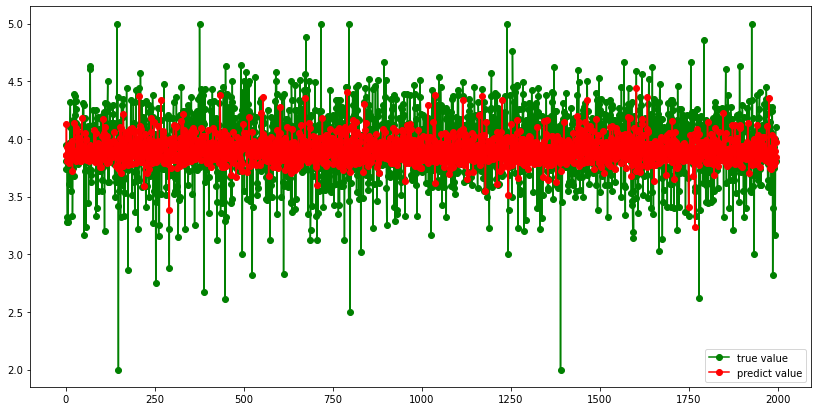

In [38]:
# 划分训练和测试集
# 指定特征测试
#features_selection = ['num_pages', 'ratings_count', 'text_reviews_count', 'publication_date']# : 还好不是因为加入词向量而没那么准确了
x_train, x_test, y_train, y_test = train_test_split(data_final.drop(columns=['average_rating']),#.iloc[:, 1:], 
                                                    data_final['average_rating'], 
                                                    test_size = 0.2, 
                                                    random_state = 1)
model = MLPRegressor(hidden_layer_sizes=(300, ), solver='adam', alpha=0.0001, activation='relu', learning_rate_init=0.001, max_iter=1000)
evaluation, model = model_fit_predict(model, x_train, y_train, x_test, y_test)

In [39]:
pprint(evaluation)

{'evaluation': {'MAE': 0.22902292750650094,
                'MSE': 0.08890854170616212,
                'R2_scores': 0.06863538594651508,
                'Variance_Score': 0.08616658341299488},
 'pred_time': 0.010998725891113281,
 'train_time': 3.492708921432495}


In [38]:
from sklearn import model_selection

In [85]:
# 交叉验证，调超参
'''
这是关于score的关键字
dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 
'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 
'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 
'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 
'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 
'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 
'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 
'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 
'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 
'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])
'''
# for hls in [50,100]:
#     mlpr = MLPRegressor(hidden_layer_sizes=(hls), 
#                         solver='adam', 
#                         alpha=0.0001, 
#                         activation='relu', 
#                         learning_rate_init=0.001, 
#                         max_iter=200, 
#                         random_state=233
#                        )
#     scores = model_selection.cross_validate(mlpr, x_data, y_data, cv = 3, scoring=['explained_variance','neg_mean_squared_error'])
#     print("MSE: %0.4f (+/- %0.3f) [hidden_layer_sizes:%s]" % (scores.mean(), scores.std(), hls))

hls=300
mlpr = MLPRegressor(hidden_layer_sizes=(hls), 
                        solver='adam', 
                        alpha=0.0001, 
                        activation='relu', 
                        learning_rate_init=0.001, 
                        max_iter=200, 
                        random_state=233
                       )
cv = model_selection.cross_validate(mlpr, x_data, y_data, cv = 3, scoring=['explained_variance','neg_mean_squared_error'])

In [87]:
cv

{'fit_time': array([3.58799911, 3.97300196, 2.78699851]),
 'score_time': array([0.02899837, 0.02899933, 0.02000022]),
 'test_explained_variance': array([-0.01150692,  0.05143903, -0.1103303 ]),
 'test_neg_mean_squared_error': array([-0.08841812, -0.08451293, -0.11840373])}

#### GradientBoostingRegressor 和差不多的效果

In [551]:
from sklearn.ensemble import GradientBoostingRegressor

In [552]:
model = GradientBoostingRegressor(loss = 'ls')
evaluation, model = model_fit_predict(model, x_train, y_train, x_test, y_test)

In [553]:
evaluation

{'train_time': 0.49399828910827637,
 'pred_time': 0.003000497817993164,
 'evaluation': {'Variance_score': 0.1835448872232618,
  'MSE': 0.11474744106550139,
  'MAE': 0.2247286404215474,
  'R2_scores': 0.18347083578021695}}

#### SVR 不行啊效果很一般

In [539]:
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor

In [549]:
features_selection = ['num_pages', 'ratings_count', 'text_reviews_count', 'publication_date']# : 还好不是因为加入词向量而没那么准确了
x_train, x_test, y_train, y_test = train_test_split(test[features_selection],#.iloc[:, 1:], 
                                                    test['average_rating'], 
                                                    test_size = 0.2, 
                                                    random_state = 0)
model = SVR()
evaluation, model = model_fit_predict(model, x_train, y_train, x_test, y_test)

In [550]:
evaluation

{'train_time': 1.0509991645812988,
 'pred_time': 0.11400008201599121,
 'evaluation': {'Variance_score': 0.07725813641823098,
  'MSE': 0.13041269381208362,
  'MAE': 0.22939917072325847,
  'R2_scores': 0.07199875750391893}}

## 0.测试坟场

#### 0.1 TF-IDF

In [90]:
# TF-IDF based on gensim
# 文档 > 文本 > 词
# TF:每个词的次数/该文本中出现最多的词的次数
# IDF：log_2(N/df), df:整个文档中包含某词的文本个数

# 流程：分词->建语料库->练tfidf模型->输入语料->输出tfidf值
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

# 做成词典，给每个词打上ID
dictionary = Dictionary(sentence)

# 以 (词id,词频) 的方式记录每个词在每个sentence中出现的次数，
# dictionary.doc2bow(text) 输入以list存放的分好词的"句子"，并返回每个词在该文本的词频
new_corpus = [dictionary.doc2bow(text) for text in sentence]

print(new_corpus[:2])
print(sentence[:2])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1)], [(6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]
[['little', 'town', 'on', 'the', 'prairie', 'little', 'house'], ['first', 'comes', 'love', 'hot', 'water', 'california']]


In [75]:
# dictionary.doc2bow 查阅已生成字典,输出为 (词id-词频)
#dictionary.doc2bow(['computer','computer','first','first','first'])
dictionary.doc2bow(['little','computer'])

[(1, 1), (750, 1)]

In [136]:
# 通过词id找到指定的词
dictionary.get(1)

'little'

In [135]:
# 通过词找到指定id
dictionary.doc2idx(['little'])

[1]

In [91]:
# 训练TF-IDF模型
tfidf = TfidfModel(new_corpus)
tfidf.save("bdc_tfidf.model")
tfidf = TfidfModel.load("bdc_tfidf.model")
# print(type(tfidf)) :: <class 'gensim.models.tfidfmodel.TfidfModel'>

In [138]:
# 抽取关键词（每句中TF-IDF最大值的词）
# corpus_tfidf = tfidf[new_corpus]
# 获取关键词 keywords
keywords = getkeyword(sentence)

#### 0.2 如何更好的分词

In [621]:
ts = 'Saul Steinberg: Illuminations'
ts = '1234556nihao ma s/y:::^23ooo'

# 在上端修改了函数,让他更好地分词
split_word(ts)

['nihao', 'ma', 's', 'y', 'ooo']

In [634]:
l1=[1,2,3]
l2=[3,4,5]

[1, 2, 3, 3, 4, 5]

#### 0.3 词向量转化,并提取关键词,用向量表达关键词

In [636]:
# 1.2.2 把文本数据转化词向量
# min_count = 1 由于数据集很小,所以有1个就会进入计算,防止词丢失
w2v_model = Word2Vec(sentences=sentence, size=50, min_count=1)
w2v_model.save("bdc_word2vec_ver2.model")
w2v_model = Word2Vec.load('bdc_word2vec_ver2.model')

In [637]:
print('查看当前word2vec模型下,computer和my的表达向量:\n', w2v_model.wv[['computer', 'my']])

查看当前word2vec模型下,computer和my的表达向量:
 [[-4.63121086e-02  9.66964066e-02  2.63721999e-02  8.62111151e-02
   8.40428248e-02  8.19149762e-02 -2.04560086e-02 -1.07447125e-01
  -9.63490689e-04  3.45063508e-02 -1.74797494e-02 -4.04152647e-02
   2.34474204e-02 -3.95941585e-02  3.68509740e-02  7.60184303e-02
   4.06926200e-02  6.09300919e-02  1.10217072e-01 -1.58834725e-03
   9.18979291e-03 -6.07841357e-04  2.80650612e-02 -1.50031850e-01
  -4.22602966e-02 -2.89089456e-02  3.29862200e-02  5.84391616e-02
  -2.56528221e-02 -1.29413158e-01 -5.29533327e-02  7.15385890e-03
   1.14342878e-02 -9.51392297e-03  1.07472025e-01  1.31036013e-01
   1.68748677e-01 -9.25661996e-02  1.98333175e-03 -4.64521646e-02
  -3.01289558e-02 -1.25499353e-01 -5.11814728e-02  5.38742952e-02
   3.03290691e-02  1.83513220e-02 -4.10342552e-02 -1.22078680e-01
   1.30178989e-03  3.76193714e-03]
 [-4.39494222e-01  9.08108413e-01  2.37039015e-01  8.79105330e-01
   6.92261159e-01  8.60764623e-01 -1.89956114e-01 -1.19116414e+00
   1.4

In [633]:
# 抽取关键词（每句中TF-IDF最大值的词）
# corpus_tfidf = tfidf[new_corpus]
# 获取关键词 keywords
keywords = getkeyword(sentence)
keywords_vec = w2v_model.wv[keywords]

In [15]:
type(keywords_vec)

numpy.ndarray

In [16]:
# 把原title的关键词，转化为N维词向量表示
title_data = keywords_vec[:len(title_data_model)]
title_data_verification = keywords_vec[-len(title_data_verification):]

检查词向量表达是否对齐,
抽查关键词查找是否相对合理,

In [17]:
print("抽取向量是否一致:", title_data[0]==keywords_vec[0])

抽取向量是否一致: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


查看关键词提取效果

In [18]:
for i in range(50):
    print(data.title[i],'关键词:', keywords[i])

Little Town on the Prairie  (Little House  #7) 关键词: little
First Comes Love (Hot Water  California #1) 关键词: california
When Santa Fell to Earth 关键词: fell
The Case of the Stinky Science Project (Jigsaw Jones  #9) 关键词: stinky
Dance Dance Dance 关键词: dance
The J.R.R. Tolkien Companion and Guide  Volume 2: Reader's Guide 关键词: guide
Mapping the Big Picture: Integrating Curriculum & Assessment K-12 关键词: assessment
The Burglar Who Thought He Was Bogart (Bernie Rhodenbarr  #7) 关键词: bogart
The Prime of Miss Jean Brodie / The Girls of Slender Means / The Driver's Seat / The Only Problem 关键词: drivers
Desperation / The Regulators: Box Set 关键词: desperation
Breaking the Spell: Religion as a Natural Phenomenon 关键词: phenomenon
Prime Time 关键词: prime
I Love Saturdays y domingos 关键词: domingos
Christmas in Noisy Village 关键词: noisy
In Search of Memory: The Emergence of a New Science of Mind 关键词: emergence
The Wapshot Chronicle 关键词: wapshot
The Gardens of Emily Dickinson 关键词: dickinson
Gates of Fire 关键词: gat

In [731]:
l1 = [[1,2],[3,4]]

TypeError: 'axis' is an invalid keyword argument for sum()